In [3]:
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib

import os
from os.path import join as opj
from os.path import join, exists, split
import time
import urllib.request
import warnings
from tqdm import tqdm
from pprint import pprint
import zipfile
import glob
warnings.filterwarnings('ignore')
from transformers import AutoFeatureExtractor, ClapModel
import torch
import torchaudio

from sklearn.linear_model import LogisticRegression, RidgeCV, Ridge
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


import pandas as pd
from nilearn import maskers
from nilearn import plotting
import tqdm

from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import concat_imgs, mean_img
import matplotlib.pyplot as plt
import nilearn
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_contrast_matrix
from importlib import reload # python 2.7 does not require this
from data_agg import *
import pickle
from nltools.data import Brain_Data, Adjacency
from nltools.stats import align

import seaborn as sns
import IPython.display as ipd
from sklearn.metrics import confusion_matrix

In [4]:
def load_transformed_data(data_folder):
    # Initialize an empty dictionary to store the data
    loaded_data_dict = {}

    # Loop through all files in the data folder
    for filename in os.listdir(data_folder):
        # Construct the full path of the file
        file_path = os.path.join(data_folder, filename)
        
        # Extract the subject ID and key from the filename
        # Assuming filenames are in the format 'sub_key.ext'
        sub, key = filename.split('_', 1)
        key = key.rsplit('.', 1)[0]  # Removes extension part to get the key
        
        #repeat
        key = key.rsplit('.', 1)[0]  # Removes extension part to get the key

        # Initialize sub dictionary if it doesn't exist
        if sub not in loaded_data_dict:
            loaded_data_dict[sub] = {}

        # Determine the file type and load accordingly
        if filename.endswith('.npy'):
            loaded_data_dict[sub][key] = np.load(file_path)
        elif filename.endswith('.pkl'):
            with open(file_path, 'rb') as file:
                loaded_data_dict[sub][key] = pickle.load(file)

        print(f"Loaded {key} from {file_path}")

    return loaded_data_dict


In [5]:
transform_masking=True
subject_ids = ["sub-001", "sub-002", "sub-003", "sub-004", "sub-005"]

with open('/data01/data/fMRI_music_genre/data_dict' + '.pkl', 'rb') as file_to_read:
    data_dict = pickle.load(file_to_read)

with open('/data01/data/fMRI_music_genre/working_data_dict' + '.pkl', 'rb') as file_to_read:
    working_data_dict = pickle.load(file_to_read)

if transform_masking:
    base_masker=working_data_dict["sub-001"]["masker"]
    selected_indices=base_masker.transform(nib.load("mask_01.nii.gz"))
    for sub in subject_ids:
        working_data_dict[sub]["train_fmri_avg"]=working_data_dict[sub]["train_fmri"].squeeze()[:,selected_indices.squeeze().astype(np.uint8)]
        working_data_dict[sub]["test_fmri_avg"]=working_data_dict[sub]["test_fmri"].squeeze()[:,selected_indices.squeeze().astype(np.uint8)]
        # working_data_dict[sub]["train_fmri_avg"]=working_data_dict[sub]["train_fmri"].squeeze()[:,:,selected_indices.squeeze().astype(np.uint8)]
        # working_data_dict[sub]["test_fmri_avg"]=working_data_dict[sub]["test_fmri"].squeeze()[:,:,selected_indices.squeeze().astype(np.uint8)]

if transform_masking:
    # Ensure the data directory exists
    data_folder = 'data'
    os.makedirs(data_folder, exist_ok=True)

    # Assuming working_data_dict is your main dictionary and 'sub' is defined
    for sub in subject_ids:
        for key, value in working_data_dict[sub].items():
            # Convert the value to a numpy array if it's not already one 
            print(key)

            # Define the path for the output file
            file_path = os.path.join(data_folder, f'{sub}_{key}.npy')

            # Check if the value is a numpy array
            if isinstance(value, np.ndarray):
                # Save the numpy array to a file with .npy extension
                np.save(file_path + '.npy', value)
                print(f"Saved {key} as an array to {file_path}.npy")
            else:
                # Save other types of data using pickle with .pkl extension
                with open(file_path + '.pkl', 'wb') as file:
                    pickle.dump(value, file, protocol=pickle.HIGHEST_PROTOCOL)
                print(f"Saved {key} using pickle to {file_path}.pkl")

            print(f"Saved {key} to {file_path}")      

else:
    # Use the function
    data_folder = 'data'  # Specify the data folder path
    working_data_dict = load_transformed_data(data_folder)

train_fmri
Saved train_fmri using pickle to data/sub-001_train_fmri.npy.pkl
Saved train_fmri to data/sub-001_train_fmri.npy
train_audio_feat
Saved train_audio_feat using pickle to data/sub-001_train_audio_feat.npy.pkl
Saved train_audio_feat to data/sub-001_train_audio_feat.npy
train_genre
Saved train_genre using pickle to data/sub-001_train_genre.npy.pkl
Saved train_genre to data/sub-001_train_genre.npy
train_audio
Saved train_audio using pickle to data/sub-001_train_audio.npy.pkl
Saved train_audio to data/sub-001_train_audio.npy
test_fmri
Saved test_fmri using pickle to data/sub-001_test_fmri.npy.pkl
Saved test_fmri to data/sub-001_test_fmri.npy
test_audio_feat
Saved test_audio_feat using pickle to data/sub-001_test_audio_feat.npy.pkl
Saved test_audio_feat to data/sub-001_test_audio_feat.npy
test_genre
Saved test_genre using pickle to data/sub-001_test_genre.npy.pkl
Saved test_genre to data/sub-001_test_genre.npy
test_audio
Saved test_audio using pickle to data/sub-001_test_audio.npy.

In [6]:
df_captions = pd.read_csv('/srv/nfs-data/sisko/matteoc/music' + '/brain2music-captions.csv')
print(df_captions.head())
captions_array = df_captions.to_numpy()
caption_dict = {item[0].split('_')[0]: item[1] for item in captions_array}

for subj in subject_ids:

    train_stim_name_list = working_data_dict[subj]['train_stim_name']
    train_stim_caption_list = []

    for file_path in train_stim_name_list:
        genre_number = file_path.split('/')[-1].replace('.wav', '')
        caption = caption_dict.get(genre_number, "Caption not found")
        train_stim_caption_list.append(caption)

    working_data_dict[subj]['train_stim_caption'] = train_stim_caption_list


for subj in subject_ids:

    test_stim_name_list = working_data_dict[subj]['test_stim_name']
    test_stim_caption_list = []

    for file_path in test_stim_name_list:
        genre_number = file_path.split('/')[-1].replace('.wav', '')
        caption = caption_dict.get(genre_number, "Caption not found")
        test_stim_caption_list.append(caption)

    working_data_dict[subj]['test_stim_caption'] = test_stim_caption_list



                ID                                             DescEN
0  blues.00000_15s  Heavy blues with male vocals. Simple cutting w...
1  blues.00002_15s  Rhythmic blues. Obligatory trumpet obbligato a...
2  blues.00005_15s  Slow blues musical piece. Sentimental atmosphe...
3  blues.00006_15s  This blues is played with twin guitars only. T...
4  blues.00010_15s  This is an instrumental piece with electric gu...


In [7]:
import pandas as pd

def process_data(data_dict, key_suffix, features_key, genre_key, stim_name_key, fmri_key, stim_caption_key):
    # Create DataFrame for fMRI and stimulus names
    df = pd.DataFrame(data_dict[fmri_key], dtype=float)
    df['Stimulus'] = data_dict[stim_name_key]
    
    # Group by 'Caption' and calculate the mean for fMRI data
    fmri_avg = df.groupby('Stimulus').mean().reset_index()
    
    # Create DataFrame for audio features and stimulus names
    df_features = pd.DataFrame(data_dict[features_key], dtype=float)
    df_features['Stimulus'] = data_dict[stim_name_key]
    
    # Group by 'Caption' and calculate the mean for audio features
    features_avg = df_features.groupby('Stimulus').mean().reset_index()
    
    # Handle genres (assuming genre data is aligned with stimuli names)
    df_genre = pd.DataFrame(data_dict[genre_key], columns=['Genre'])
    df_genre['Stimulus'] = data_dict[stim_name_key]
    
    # Since genre should be consistent for the same caption, we can take the first occurrence
    genre_avg = df_genre.groupby('Stimulus').first().reset_index()

    # Handle genres (assuming genre data is aligned with stimuli names)
    df_caption = pd.DataFrame(data_dict[stim_caption_key], columns=['Caption'])
    df_caption['Stimulus'] = data_dict[stim_name_key]
    
    # Since genre should be consistent for the same caption, we can take the first occurrence
    caption_avg = df_caption.groupby('Stimulus').first().reset_index()
    
    return {
        key_suffix + '_audio_feat': features_avg.drop(columns='Stimulus').values,
        key_suffix + '_genre': genre_avg['Genre'].values,
        key_suffix + '_stim_name_avg': fmri_avg['Stimulus'].values,
        key_suffix + '_caption_avg': caption_avg['Caption'].values,
        key_suffix + '_fmri_avg': fmri_avg.drop(columns='Stimulus').values
    }


working_data_dict_avg = {}
for sub in subject_ids:
    working_data_dict_avg[sub] = {}

    # Process training data
    working_data_dict_avg[sub].update(
        process_data(
            working_data_dict[sub],
            'train',
            'train_audio_feat',
            'train_genre',
            'train_stim_name',
            'train_fmri_avg',
            'train_stim_caption'
        )
    )

    # Process testing data
    working_data_dict_avg[sub].update(
        process_data(
            working_data_dict[sub],
            'test',
            'test_audio_feat',
            'test_genre',
            'test_stim_name',
            'test_fmri_avg',
            'test_stim_caption'
        )
    )



In [8]:
# Function to print dimensions and examples
def print_key_details(data_dict):
    for key, value in data_dict.items():
        # Print the dimensions of each item
        if isinstance(value, np.ndarray):
            print(f"Key: {key}, Dimensions: {value.shape}")
        else:
            print(f"Key: {key}, Type: {type(value)}")
        
        # Print some example data for genre and stimuli names
        if 'genre' in key or 'stim_name' in key:
            print(f"Example data for {key}: {value[:5]}")  # Print first 5 examples

for sub in subject_ids:
    # Assuming working_data_dict_avg is already populated and structured correctly
    print_key_details(working_data_dict_avg[sub])

import pickle
import os


save_out_data=True

if save_out_data:
    # Ensure the 'data' directory exists
    if not os.path.exists('data'):
        os.makedirs('data')

    # Path to save the pickle file
    pickle_file_path = 'data/working_data_dict_avg.pkl'

    # Serialize and save the dictionary using pickle
    with open(pickle_file_path, 'wb') as file:
        pickle.dump(working_data_dict_avg, file)

    print(f'Data successfully saved to {pickle_file_path}')
    
else:
    # Path to the pickle file
    pickle_file_path = 'data/working_data_dict_avg.pkl'

    # Deserialize the dictionary from the pickle file
    with open(pickle_file_path, 'rb') as file:
        working_data_dict_avg = pickle.load(file)

    print('Data successfully loaded.')
    print(working_data_dict_avg)  # Optionally print or inspect some part of the loaded data




Key: train_audio_feat, Dimensions: (480, 512)
Key: train_genre, Dimensions: (480,)
Example data for train_genre: ['blues' 'blues' 'blues' 'blues' 'blues']
Key: train_stim_name_avg, Dimensions: (480,)
Example data for train_stim_name_avg: ['/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00000.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00002.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00005.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00006.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00010.wav']
Key: train_caption_avg, Dimensions: (480,)
Key: train_fmri_avg, Dimensions: (480, 833)
Key: test_audio_feat, Dimensions: (60, 512)
Key: test_genre, Dimensions: (60,)
Example data for test_genre: ['blues' 'blues' 'blues' 'blues' 'blues']
Key: test_stim_name_avg, Dimensions: (60,)
Example data for test_stim_name_avg: ['/data01/data/fMRI_music_genre/data_wav/gen

In [9]:
print(working_data_dict_avg['sub-001']['train_audio_feat'].shape)
print(working_data_dict_avg['sub-001']['train_fmri_avg'].shape)
print(working_data_dict_avg['sub-001']['train_genre'].shape)
print(working_data_dict_avg['sub-001']['train_stim_name_avg'].shape)
print(working_data_dict_avg['sub-001']['train_caption_avg'].shape)
print(working_data_dict_avg['sub-001']['test_audio_feat'].shape)
print(working_data_dict_avg['sub-001']['test_fmri_avg'].shape)
print(working_data_dict_avg['sub-001']['test_genre'].shape)
print(working_data_dict_avg['sub-001']['test_stim_name_avg'].shape)
print(working_data_dict_avg['sub-001']['test_caption_avg'].shape)


print(working_data_dict_avg['sub-001']['train_stim_name_avg'][94:98])
print(working_data_dict_avg['sub-001']['train_genre'][94:98])
print(working_data_dict_avg['sub-001']['train_caption_avg'][94:98])

(480, 512)
(480, 833)
(480,)
(480,)
(480,)
(60, 512)
(60, 833)
(60,)
(60,)
(60,)
['/data01/data/fMRI_music_genre/data_wav/genres_original/classical/classical.00095.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/classical/classical.00097.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/country/country.00006.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/country/country.00008.wav']
['classical' 'classical' 'country' 'country']
['This piece consists of several string instruments. A beautiful violin solo is heard. In the background, simple harmonies are playing. Suddenly an intense tone of multiple stringed instruments is heard, before returning to the original beautiful violin solo.'
 'The violin, harpsichord and cello are playing. The melody is performed by the violins. The tune transitions from minor to major and back to minor again.'
 'This is honest singing country. Light country guitar arpeggios and a harmonica can be heard. In the backgroun

In [10]:
# STRONGER FUNCTIONAL ALIGNMENT

target_sub="sub-001"

# X_train_aligned = [working_data_dict_avg[source_sub]["train_fmri_avg"]]
# X_test_aligned  = [working_data_dict_avg[source_sub]["test_fmri_avg"]]
X_train_aligned = []
X_test_aligned  = []


for source_sub in subject_ids:

    print(source_sub)
    source_train=working_data_dict_avg[source_sub]["train_fmri_avg"]
    target_train=working_data_dict_avg[target_sub]["train_fmri_avg"]

    source_test=working_data_dict_avg[source_sub]["test_fmri_avg"]
    target_test=working_data_dict_avg[target_sub]["test_fmri_avg"]

    
    aligner=RidgeCV(alphas=[1e2,1e3,1e4,5e4], fit_intercept=True)
    aligner.fit(source_train,target_train)

    aligned_source_test=aligner.predict(source_test)
    aligned_source_train=aligner.predict(source_train)

    aligned_source_train_adj = (aligned_source_train - aligned_source_train.mean(0)) / (1e-8 + aligned_source_train.std(0))
    aligned_source_train_adj = target_train.std(0) * aligned_source_train_adj + target_train.mean(0)

    # Align and adjust source_test dataset
    aligned_source_test_adj = (aligned_source_test - aligned_source_test.mean(0)) / (1e-8 + aligned_source_test.std(0))
    aligned_source_test_adj = target_train.std(0) * aligned_source_test_adj + target_train.mean(0)
    
    X_train_aligned.append(aligned_source_train_adj)
    X_test_aligned.append(aligned_source_test_adj)
    
#concatenate all

X_train_aligned = np.concatenate(X_train_aligned,0)
X_test_aligned = np.concatenate(X_test_aligned,0)

#concatenate all the other keys

train_audio_feat_aligned = np.concatenate([working_data_dict_avg[sub]["train_audio_feat"] for sub in subject_ids],0)
test_audio_feat_aligned = np.concatenate([working_data_dict_avg[sub]["test_audio_feat"] for sub in subject_ids],0)

train_genre_aligned = np.concatenate([working_data_dict_avg[sub]["train_genre"] for sub in subject_ids],0)
test_genre_aligned = np.concatenate([working_data_dict_avg[sub]["test_genre"] for sub in subject_ids],0)

train_stim_name_avg_aligned = np.concatenate([working_data_dict_avg[sub]["train_stim_name_avg"] for sub in subject_ids],0)
test_stim_name_avg_aligned = np.concatenate([working_data_dict_avg[sub]["test_stim_name_avg"] for sub in subject_ids],0)

train_caption_avg_aligned = np.concatenate([working_data_dict_avg[sub]["train_caption_avg"] for sub in subject_ids],0)
test_caption_avg_aligned = np.concatenate([working_data_dict_avg[sub]["test_caption_avg"] for sub in subject_ids],0)


sub-001
sub-002
sub-003


sub-004
sub-005


In [11]:
from diffusers import MusicLDMPipeline

repo_id = "ucsd-reach/musicldm"
pipe = MusicLDMPipeline.from_pretrained(repo_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

from transformers import AutoFeatureExtractor, ClapModel, ClapProcessor

clap_model_id="laion/larger_clap_music_and_speech"
model = ClapModel.from_pretrained(clap_model_id).to("cuda")
processor = ClapProcessor.from_pretrained(clap_model_id)

# model = ClapModel.from_pretrained("laion/clap-htsat-unfused").to("cuda:1")
feature_extractor = AutoFeatureExtractor.from_pretrained(clap_model_id)

Loading pipeline components...: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


In [12]:
train_text_ldm = []
with torch.no_grad():
    for tx in tqdm.tqdm(train_caption_avg_aligned):
        text_ldm = pipe._encode_prompt(tx, device='cuda', num_waveforms_per_prompt=1, do_classifier_free_guidance=False)
        train_text_ldm.append(text_ldm)

test_text_ldm = []
with torch.no_grad():
    for tx in tqdm.tqdm(test_caption_avg_aligned):
        text_ldm = pipe._encode_prompt(tx, device='cuda', num_waveforms_per_prompt=1, do_classifier_free_guidance=False)
        test_text_ldm.append(text_ldm)

train_text_feat_avg_aligned=torch.stack(train_text_ldm).squeeze()
test_text_feat_avg_aligned=torch.stack(test_text_ldm).squeeze()

100%|██████████| 300/300 [00:01<00:00, 150.56it/s]


In [13]:
train_text_feat_avg_aligned.shape

torch.Size([2400, 512])

## Fine Tuning on MusicCaps

In [12]:
from datasets import load_dataset

ds = load_dataset('google/MusicCaps', split='train')

In [13]:
import subprocess
import os
from pathlib import Path

def download_clip(
    video_identifier,
    output_filename,
    start_time,
    end_time,
    tmp_dir='/tmp/musiccaps/',
    num_attempts=5,
    url_base='https://www.youtube.com/watch?v='
):
    status = False

    command = f"""
        yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "{output_filename}" --download-sections "*{start_time}-{end_time}" {url_base}{video_identifier}
    """.strip()

    attempts = 0
    while True:
        try:
            output = subprocess.check_output(command, shell=True,
                                                stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as err:
            attempts += 1
            if attempts == num_attempts:
                return status, err.output
        else:
            break

    # Check if the video was successfully saved.
    status = os.path.exists(output_filename)
    return status, 'Downloaded'




In [14]:
from datasets import Audio

samples_to_load = 5521      # How many samples to load
cores = 4                 # How many processes to use for the loading
sampling_rate = 44100     # Sampling rate for the audio, keep in 44100
writer_batch_size = 1000  # How many examples to keep in memory per worker. Reduce if OOM.
data_dir = "/srv/nfs-data/sisko/matteoc/music/music_data_caps" # Where to save the data

# Just select some samples 
ds = ds.select(range(samples_to_load))

# Create directory where data will be saved
data_dir = Path(data_dir)
data_dir.mkdir(exist_ok=True, parents=True)

def process(example):
    outfile_path = str(data_dir / f"{example['ytid']}.wav")
    status = True
    if not os.path.exists(outfile_path):
        status = False
        status, log = download_clip(
            example['ytid'],
            outfile_path,
            example['start_s'],
            example['end_s'],
        )

    example['audio'] = outfile_path
    example['download_status'] = status
    return example



In [15]:
ds = ds.map(
        process,
        num_proc=cores,
        writer_batch_size=writer_batch_size,
        keep_in_memory=False
    ).cast_column('audio', Audio(sampling_rate=sampling_rate))

In [19]:
caps_audio = []
caps_sr = []
caps_caption = []
for i in tqdm.tqdm(range(len(ds))):
    try:
        audio, sr = torchaudio.load(ds[i]['audio']['path'])
        caption = ds[i]['caption']
        caps_audio.append(audio)
        caps_sr.append(sr)
        caps_caption.append(caption)
    except:
        continue


caps_audio_mono = []
for audio_stereo in caps_audio:
    mono_waveform = torch.mean(audio_stereo, dim=0, keepdim=True)
    caps_audio_mono.append(mono_waveform)


100%|██████████| 5521/5521 [05:37<00:00, 16.38it/s]


In [23]:
len(caps_audio_mono)

5402

In [24]:
audio_feat_caps=[]
text_feat_caps=[]
resampler = torchaudio.transforms.Resample(orig_freq=44100, new_freq=48000)

with torch.no_grad():
    for wv,tx,sr in tqdm.tqdm(list(zip(caps_audio_mono,caps_caption,caps_sr))):
        wv = resampler(wv)
        inputs = processor(text=tx, audios=wv.squeeze(), return_tensors="pt", sampling_rate=48_000)
        outputs = model(**inputs.to('cuda'))
        audio_feat_caps.append(outputs.audio_embeds)
        text_feat_caps.append(outputs.text_embeds)

  0%|          | 0/5402 [00:00<?, ?it/s]

100%|██████████| 5402/5402 [29:36<00:00,  3.04it/s]


In [25]:
audio_feat_caps=torch.stack(audio_feat_caps).squeeze()
# torch.save(audio_feat_caps, "/srv/nfs-data/sisko/matteoc/music/feature/audio_feat_clap_cap.pt")
# np.save('/srv/nfs-data/sisko/matteoc/music/feature/text_caption_cap.npy', caps_caption)

In [14]:
audio_feat_caps = torch.load("/srv/nfs-data/sisko/matteoc/music/feature/audio_feat_clap_cap.pt")
caps_caption = np.load('/srv/nfs-data/sisko/matteoc/music/feature/text_caption_cap.npy').tolist()

In [15]:
text_feat_cap_ldm = []
with torch.no_grad():
    for tx in tqdm.tqdm(caps_caption):
        text_ldm = pipe._encode_prompt(tx, device='cuda', num_waveforms_per_prompt=1, do_classifier_free_guidance=False)
        text_feat_cap_ldm.append(text_ldm)

text_feat_cap_ldm=torch.stack(text_feat_cap_ldm).squeeze()


100%|██████████| 5402/5402 [00:36<00:00, 146.92it/s]


In [16]:
import torch.nn as nn
import torch.optim as optim

input_dim = 512
output_dim = 512
linear_layer = nn.Linear(input_dim, output_dim).to('cuda')
criterion = nn.MSELoss()
optimizer = optim.Adam(linear_layer.parameters(), lr=0.0001, weight_decay=1e-6)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    linear_layer.train()
    optimizer.zero_grad() 
    audio_feat_train_output = linear_layer(audio_feat_caps)
    loss = criterion(audio_feat_train_output, text_feat_cap_ldm.float()) 
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')



Epoch [20/1000], Loss: 0.002355283359065652
Epoch [40/1000], Loss: 0.001877330243587494
Epoch [60/1000], Loss: 0.0016285101883113384
Epoch [80/1000], Loss: 0.0014842487871646881
Epoch [100/1000], Loss: 0.0013923145597800612
Epoch [120/1000], Loss: 0.0013296029064804316
Epoch [140/1000], Loss: 0.0012847541365772486
Epoch [160/1000], Loss: 0.0012515101116150618
Epoch [180/1000], Loss: 0.0012261265655979514
Epoch [200/1000], Loss: 0.0012062409659847617
Epoch [220/1000], Loss: 0.00119030533824116
Epoch [240/1000], Loss: 0.001177275087684393
Epoch [260/1000], Loss: 0.0011664272751659155
Epoch [280/1000], Loss: 0.0011572502553462982
Epoch [300/1000], Loss: 0.0011493742931634188
Epoch [320/1000], Loss: 0.0011425281409174204
Epoch [340/1000], Loss: 0.0011365085374563932
Epoch [360/1000], Loss: 0.0011311619309708476
Epoch [380/1000], Loss: 0.0011263700434938073
Epoch [400/1000], Loss: 0.0011220402084290981
Epoch [420/1000], Loss: 0.0011181002482771873
Epoch [440/1000], Loss: 0.00111449172254651

## Back to brain

In [17]:
linear_layer.eval()  
with torch.no_grad():  
    train_feature_finetuned = linear_layer(torch.tensor(train_audio_feat_aligned, dtype=torch.float32, device='cuda'))
    test_loss = criterion(train_feature_finetuned, train_text_feat_avg_aligned)
    
print(f'Test Loss: {test_loss.item()}')

Test Loss: 0.001088038319721818


In [18]:
train_feature_finetuned.shape

torch.Size([2400, 512])

In [19]:
linear_layer.eval()  
with torch.no_grad():  
    test_feature_finetuned = linear_layer(torch.tensor(test_audio_feat_aligned, dtype=torch.float32, device='cuda'))
    test_loss = criterion(test_feature_finetuned, test_text_feat_avg_aligned)
    
print(f'Test Loss: {test_loss.item()}')

Test Loss: 0.0011006941786035895


In [20]:
test_feature_finetuned.shape

torch.Size([300, 512])

In [21]:
le=LabelEncoder()

train_genre_enc=le.fit_transform(train_genre_aligned)
test_genre_enc=le.transform(test_genre_aligned)

X_train=X_train_aligned.copy()
X_test=X_test_aligned.copy()

clf_genre = LogisticRegression(C=10,random_state=0).fit(X_train, train_genre_enc)

y_pred_genre = clf_genre.predict(X_test)

print(classification_report(test_genre_enc,y_pred_genre))

              precision    recall  f1-score   support

           0       0.48      0.37      0.42        30
           1       0.76      0.97      0.85        30
           2       0.39      0.50      0.44        30
           3       0.37      0.37      0.37        30
           4       0.64      0.70      0.67        30
           5       0.65      0.57      0.61        30
           6       0.54      0.50      0.52        30
           7       0.61      0.67      0.63        30
           8       0.40      0.40      0.40        30
           9       0.14      0.10      0.12        30

    accuracy                           0.51       300
   macro avg       0.50      0.51      0.50       300
weighted avg       0.50      0.51      0.50       300



In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, normalize

# brain_to_latent=RidgeCV(alphas=[1e-2,0.1,1,2,5,8,10,15,20,50,1e2,1e3])
brain_to_latent=Ridge(alpha=20)

brain_to_latent.fit(X_train, train_feature_finetuned.cpu())

Ridge(alpha=20)

In [23]:
audio_feat_to_generate = brain_to_latent.predict(X_test)
audio_feat_to_generate = torch.tensor(audio_feat_to_generate, dtype=torch.float32, device='cuda')

In [24]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(test_feature_finetuned[:60].cpu())

distances, top_indices = nbrs.kneighbors(audio_feat_to_generate.cpu())


In [761]:
start_track = 59   # 4, 5 --> (blues);  7 (classical); 17 (country); 20 (disco); 26, 27 (hip-hop); 32, 34 (jazz)
                   # 37 (metal); 44, 45 (pop); 48 (reggae); 56, 57 (rock)

stop_track = start_track + 1

In [762]:
print(test_genre_aligned[:60][start_track])
print(test_stim_name_avg_aligned[:60][start_track:stop_track])
print(test_caption_avg_aligned[:60][start_track:stop_track])

print(test_stim_name_avg_aligned[:60][start_track])
print(test_genre_aligned[:60][top_indices[start_track]])
print(test_stim_name_avg_aligned[:60][top_indices[start_track]])


rock
['/data01/data/fMRI_music_genre/data_wav/genres_original/rock/rock.00075.wav']
['Rhythmic rock. The vocals are lively and the chorus powerful. The electric guitar colours the melody with light cuts, while the drums and bass provide the rhythmic parts. This music is perfect for energetic and action-packed scenes.']
/data01/data/fMRI_music_genre/data_wav/genres_original/rock/rock.00075.wav
['metal' 'disco' 'metal' 'hiphop' 'rock']
['/data01/data/fMRI_music_genre/data_wav/genres_original/metal/metal.00063.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/disco/disco.00075.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/metal/metal.00064.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/hiphop/hiphop.00019.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/rock/rock.00032.wav']


In [763]:
audio_pred_from_brain = pipe(prompt_embeds=audio_feat_to_generate[start_track:stop_track], num_inference_steps=50, audio_length_in_s=10.0).audios[0]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 38.60it/s]


In [764]:
from IPython.display import Audio

Audio(audio_pred_from_brain, rate=16000)

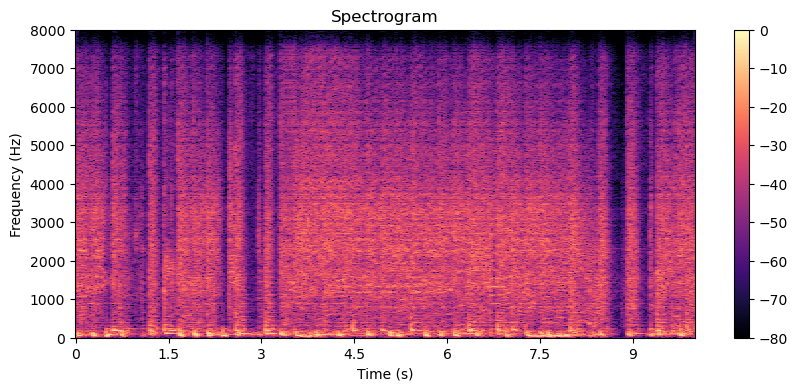

In [765]:
import librosa

X_pred = librosa.stft(audio_pred_from_brain)
Xdb_pred = librosa.amplitude_to_db(abs(X_pred), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(Xdb_pred, sr=16000, x_axis='time', y_axis='hz',)
plt.colorbar()
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


In [766]:
audio_vera = pipe(prompt_embeds=test_text_feat_avg_aligned[start_track:stop_track], num_inference_steps=50, audio_length_in_s=10.0).audios[0]
audio_vera_wav = librosa.load(test_stim_name_avg_aligned[:60][start_track:stop_track][0], sr=16000)

100%|██████████| 50/50 [00:01<00:00, 35.92it/s]


In [767]:
audio_vera_wav[0].shape, audio_vera.shape

((480214,), (160000,))

In [768]:
Audio(audio_vera_wav[0], rate=16000)

In [769]:
Audio(audio_vera, rate=16000)

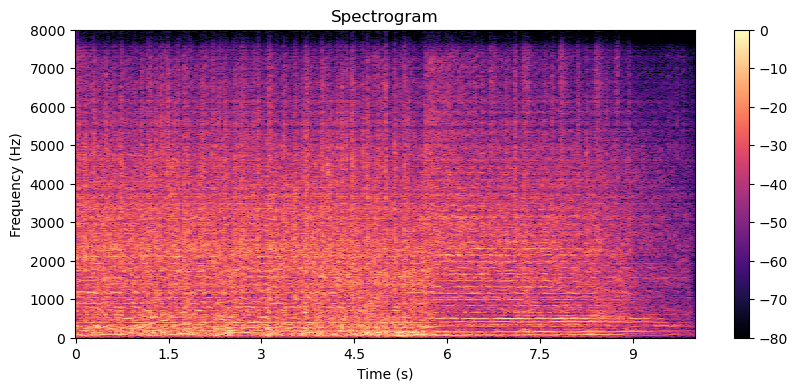

In [770]:
X_vera = librosa.stft(audio_vera)
Xdb_vera = librosa.amplitude_to_db(abs(X_vera), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(Xdb_vera, sr=16000, x_axis='time', y_axis='hz',)
plt.colorbar()
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [771]:
from scipy.stats import pearsonr

def identification_accuracy(P, T):
    n = P.shape[0]
    C = np.zeros((n, n))
    
    # Compute the correlation matrix
    for i in tqdm.trange(n):
        for j in range(n):
            C[i, j], _ = pearsonr(P[i], T[j])
    
    # Compute identification accuracy per prediction
    id_acc = np.zeros(n)
    for i in tqdm.trange(n):
        id_acc[i] = (C[i, i] > C[i]).sum() 
        id_acc[i] = id_acc[i] / (n - 1)

    # Average identification accuracy
    overall_id_acc = np.mean(id_acc)
    
    return overall_id_acc

In [772]:
id_accs = []

id_accs=[]
for i in range(5):
    
    id_acc=identification_accuracy(audio_feat_to_generate[60*i:60*(i+1)].cpu(),test_feature_finetuned[60*i:60*(i+1)].cpu())
    id_accs.append(id_acc)

mean_acc = np.mean(id_accs)
std_acc = np.std(id_accs)

np.mean(id_accs), np.std(id_accs)

print(mean_acc, std_acc)

100%|██████████| 60/60 [00:00<00:00, 240821.28it/s]

0.8838418079096046 0.019157791391111543
